# <입원 기간 예측 알고리즘>

**이화여자대학교  
윤하영 이선민 이진솔 조은서**

In [77]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import RandomizedSearchCV
import xgboost
from sklearn import preprocessing
import xgboost as xgb
from xgboost.sklearn import XGBRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score, mean_squared_error
!pip install lightgbm
import lightgbm as lgb
from sklearn.preprocessing import StandardScaler
from lightgbm import plot_importance

In [6]:
df = pd.read_csv("train_data.csv")

# 1. EDA

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 318438 entries, 0 to 318437
Data columns (total 18 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   case_id                            318438 non-null  int64  
 1   Hospital_code                      318438 non-null  int64  
 2   Hospital_type_code                 318438 non-null  object 
 3   City_Code_Hospital                 318438 non-null  int64  
 4   Hospital_region_code               318438 non-null  object 
 5   Available Extra Rooms in Hospital  318438 non-null  int64  
 6   Department                         318438 non-null  object 
 7   Ward_Type                          318438 non-null  object 
 8   Ward_Facility_Code                 318438 non-null  object 
 9   Bed Grade                          318325 non-null  float64
 10  patientid                          318438 non-null  int64  
 11  City_Code_Patient                  3139

In [8]:
df.head()

,case_id,Hospital_code,Hospital_type_code,City_Code_Hospital,Hospital_region_code,Available Extra Rooms in Hospital,Department,Ward_Type,Ward_Facility_Code,Bed Grade,patientid,City_Code_Patient,Type of Admission,Severity of Illness,Visitors with Patient,Age,Admission_Deposit,Stay
0,1,8,c,3,Z,3,radiotherapy,R,F,2.0,31397,7.0,Emergency,Extreme,2,51-60,4911.0,0-10
1,2,2,c,5,Z,2,radiotherapy,S,F,2.0,31397,7.0,Trauma,Extreme,2,51-60,5954.0,41-50
2,3,10,e,1,X,2,anesthesia,S,E,2.0,31397,7.0,Trauma,Extreme,2,51-60,4745.0,31-40
3,4,26,b,2,Y,2,radiotherapy,R,D,2.0,31397,7.0,Trauma,Extreme,2,51-60,7272.0,41-50
4,5,26,b,2,Y,2,radiotherapy,S,D,2.0,31397,7.0,Trauma,Extreme,2,51-60,5558.0,41-50


#### 범주형 변수  
- Hospital_type_code: a~g
- Hospital_region_code: X,Y,Z
- Department: gynecology(부인과), anesthesia(마취과), radiotherapy(방사선 치료), TB & Chest disease(결핵 & 폐병), surgery(수술)
- Ward_Type(병동): P~U
- Ward_Facility_Code: A~F
- Type of Admission: Trauma, Emergency, Urgent
- Severity of Illness: Minor, Moderate, Extreme
- Age: 10세 단위로 0-10부터 91-100까지
- Stay: 10일 단위로 0-10부터 'More than 100 Days'까지

### Hospital_Region_Code, Hospital_type_code, Hospital_code 세 변수의 관계 확인

In [9]:
hospital = df.groupby(['Hospital_type_code','Hospital_code'])['Hospital_region_code'].min().reset_index()
hospital = hospital.sort_values(by=['Hospital_region_code','Hospital_type_code'])
hospital = hospital[['Hospital_region_code', 'Hospital_type_code', 'Hospital_code']]
hospital.reset_index(drop=True)

,Hospital_region_code,Hospital_type_code,Hospital_code
0,X,a,4
1,X,a,5
2,X,a,6
3,X,a,7
4,X,a,14
5,X,a,23
6,X,a,24
7,X,a,29
8,X,b,28
9,X,e,10


### 상관관계

<AxesSubplot:>

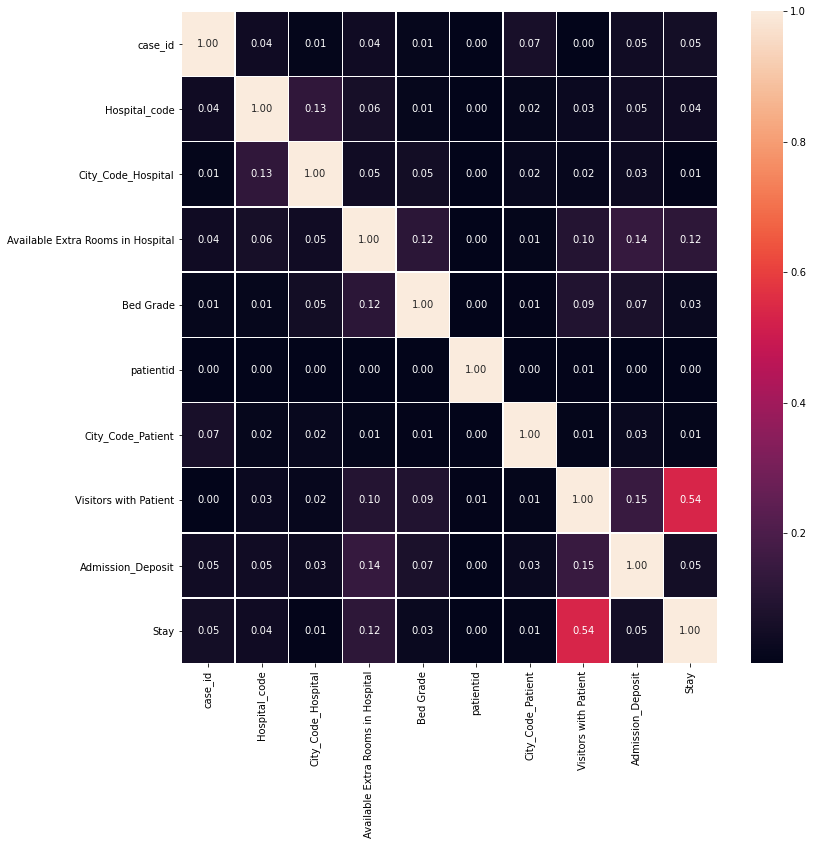

In [10]:
# 종속변수인 Stay 수치화 후 상관관계 확인
stay_mapping = {'0-10':5, '11-20':15, '21-30':25, '31-40':35, '41-50':45, '51-60':55, '61-70':65, '71-80':75, '81-90':85, '91-100':95, 'More than 100 Days':105}
df['Stay'] = df['Stay'].map(stay_mapping)

plt.figure(figsize=(12,12))
sns.heatmap(data=df.corr().abs(), annot=True, fmt='.2f', linewidths=.5)

- Stay와 VIsitors with Patient 간의 높은 상관관계 확인

## 2. 전처리

In [11]:
# 수치형이면서 범주형인 변수 원핫인코딩 위해 str화
df['Hospital_code'] = df['Hospital_code'].astype(str)
df['City_Code_Hospital'] = df['City_Code_Hospital'].astype(str)
df['City_Code_Patient'] = df['City_Code_Patient'].astype(str)

In [12]:
# 범주형 변수 원핫인코딩
cat_df = df.loc[:,['Hospital_code', 'Hospital_type_code','City_Code_Hospital', 'City_Code_Patient','Hospital_region_code','Department','Ward_Type','Ward_Facility_Code','Type of Admission']]
remain_df = df.loc[:,['Available Extra Rooms in Hospital', 'Bed Grade','Visitors with Patient','Age','Admission_Deposit','Severity of Illness','Stay']]
dum_data = pd.get_dummies(cat_df)
df2 = pd.concat([remain_df, dum_data], axis=1)

In [13]:
# Stay 중간값 처리 - 'Stay More than 100 Days'는 105로 처리
#stay_mapping = {'0-10':5, '11-20':15, '21-30':25, '31-40':35, '41-50':45, '51-60':55, '61-70':65, '71-80':75, '81-90':85, '91-100':95, 'More than 100 Days':105}

# Age 처리
age_mapping = {'0-10':0, '11-20':1, '21-30':2, '31-40':3, '41-50':4, '51-60':5, '61-70':6, '71-80':7, '81-90':8, '91-100':9}
df2['Age'] = df2['Age'].map(age_mapping)

# Severity of Illness 처리
illness_mapping = {'Extreme':2, 'Minor':0, 'Moderate':1}
df2['Severity of Illness'] = df2['Severity of Illness'].map(illness_mapping)

In [14]:
# 결측치 처리
print("Data set의 결측치: ")
print(df2.isna().sum().sum())

Data set의 결측치: 
113


In [15]:
# 31만개의 data set에 비해 결측치가 매우 적다고 판단하여 결측치 모두 삭제
df3 = df2.dropna()

# 3. 모델링

In [16]:
X_data = df3.drop(['Stay'], axis=1)
y_data = df3['Stay']
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size = 0.3, random_state=777)

## 1 - RandomForest

In [51]:
# 정답값에 +- 15일 오차를 허용한 새로운 정확도 산출 함수
def new_accuracy(y_test, pred):
    accuracy_count=0
    for label,y in zip(y_test, pred):
        if ((y >= label-15) & (y <= label+15)):
            accuracy_count += 1
    return accuracy_count/len(pred)

### 1) Base Model

In [83]:
base_rf = RandomForestRegressor(n_estimators=100,n_jobs=-1, random_state=0)
base_rf.fit(X_train, y_train)
base_rf_pred = base_rf.predict(X_test)

In [85]:
print("Random Forest Base Model")
print("RMSE: ", np.round(mean_squared_error(y_test, base_rf_pred)**0.5,3))
print("r2 score: ", np.round(r2_score(y_test, base_rf_pred),3))


Random Forest Base Model
RMSE:  15.705
r2 score:  0.465


In [86]:
print("new accuracy: ", np.round(new_accuracy(y_test, base_rf_pred),3))

new accuracy:  0.742


In [54]:
def plot_feature_importance(importance,names,model_type):

    #Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)

    #Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)

    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)
    fi_df = fi_df[:20] # 상위 20개 feature 추출

    #Define size of bar plot
    plt.figure(figsize=(10,8))
    #Plot Searborn bar chart
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    #Add chart labels
    plt.title(model_type + 'FEATURE IMPORTANCE')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')

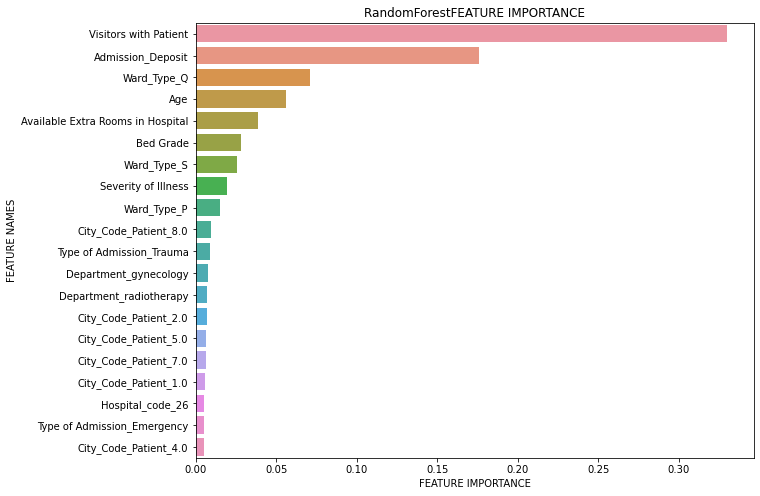

In [55]:
plot_feature_importance(base_rf.feature_importances_, X_data.columns, 'RandomForest')

## 2 - XGB Regressor
### 1) Base Model

In [87]:
xgb_model = xgb.XGBRegressor(n_estimators=100, learning_rate = 0.08, max_depth=5)
xgb_model.fit(X_train, y_train)

xgb_pred = xgb_model.predict(X_test) 
print("Xgb Regressor Base Model")
print("RMSE: ", np.round(np.sqrt(mean_squared_error(y_test, xgb_pred)),3))
print("r2 score: ",np.round(r2_score(y_test, xgb_pred),3))

Xgb Regressor Base Model
RMSE:  15.473
r2 score:  0.481


In [88]:
print("new accuracy: ", np.round(new_accuracy(y_test, xgb_pred),3))

new accuracy:  0.752


<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

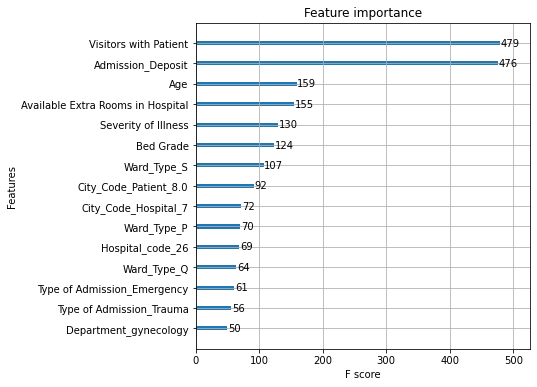

In [98]:
# Feature Importance
from xgboost import plot_importance
import matplotlib.pyplot as plt
%matplotlib inline

f, ax = plt.subplots(figsize=(6,6))
plot_importance(xgb_model, max_num_features=15, ax=ax)

- 랜덤포레스트의 Feature Importance와 크게 다르지 않음

### 2) RandomizedSearchCV Model

In [58]:
xgb = XGBRegressor()
param = {'objective':['reg:linear'],
         'learning_rate': [.03, 0.05, .07], 
         'max_depth': [4,5, 6],
         'min_child_weight': [4],
         'silent': [1],
         'subsample': [0.7],
         'colsample_bytree': [0.7],
         'n_estimators': [500]}

xgb_rand = RandomizedSearchCV(estimator=xgb, param_distributions=param, cv=2, n_jobs=-1, verbose=True)
xgb_rand.fit(X_train, y_train)
print("Best Parameters: ", xgb_rand.best_params_)
print("Best Score: ", xgb_rand.best_score_)

Fitting 2 folds for each of 9 candidates, totalling 18 fits


/scratch/kedu27/.conda/envs/notebook/lib/python3.7/site-packages/sklearn/model_selection/_search.py:282: UserWarning: The total space of parameters 9 is smaller than n_iter=10. Running 9 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:  4.7min finished


[21:30:44] WARNING: ../src/objective/regression_obj.cu:174: reg:linear is now deprecated in favor of reg:squarederror.
[21:30:44] WARNING: ../src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:31:51] WARNING: ../src/objective/regression_obj.cu:174: reg:linear is now deprecated in favor of reg:squarederror.
Best Parameters:  {'subsample': 0.7, 'silent': 1, 'objective': 'reg:linear', 'n_estimators': 500, 'min_child_weight': 4, 'max_depth': 6, 'learning_rate': 0.05, 'colsample_bytree': 0.7}
Best Score:  0.4946425070788492


In [89]:
xgb_rand_pred = xgb_rand.best_estimator_.predict(X_test)

print("RandomizedSearchCV Xgb Regressor Model")
print("RMSE: ", np.round(np.sqrt(mean_squared_error(y_test, xgb_rand_pred)),3))
print("r2 score: ",np.round(r2_score(y_test, xgb_rand_pred),3))

RandomizedSearchCV Xgb Regressor Model
RMSE:  15.241
r2 score:  0.496


In [90]:
print("new accuracy: ", np.round(new_accuracy(y_test, xgb_rand_pred),3))

new accuracy:  0.758


## 3 - Lightgbm

In [60]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
scaled_X_train = sc.fit_transform(X_train)
scaled_X_test = sc.transform(X_test)

In [61]:
hyper_params = {
    'objective': 'regression',
    'metric':{'rmse', 'mean_absolute_error'},
    'learning_rate': 0.005,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.7,
    'bagging_freq': 10,
    'verbose': 0,
    "max_depth": 6,
    "num_leaves": 64,
    "num_iterations":2000
}

lgb_train = lgb.Dataset(scaled_X_train, y_train)
lgb_eval = lgb.Dataset(scaled_X_test, y_test, reference = lgb_train)
lgbm = lgb.train(hyper_params, lgb_train, num_boost_round=1000, valid_sets = lgb_eval, early_stopping_rounds =200)

/scratch/kedu27/.conda/envs/notebook/lib/python3.7/site-packages/lightgbm/engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.067768 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	valid_0's rmse: 21.4201	valid_0's l1: 16.106
Training until validation scores don't improve for 200 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2]	valid_0's rmse: 21.4106	valid_0's l1: 16.0976
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3]	valid_0's rmse: 21.3641	valid_0's l1: 16.0597
[4]	valid_0's rmse: 21.355	valid_0's l1: 16.0514
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5]	valid_0's rmse: 21.3088	valid_0's l1: 16.0137
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6]	valid_0's rmse: 21.2654	valid_0's l1: 15.9784
[LightGBM] [Warning] No further spli

In [94]:
lgbm_pred = lgbm.predict(scaled_X_test)
print("Lightgbm Regressor Model")
print("RMSE: ", np.round(np.sqrt(mean_squared_error(y_test, lgbm_pred)),3))
print("r2 score: ",np.round(r2_score(y_test, lgbm_pred),3))

Lightgbm Regressor Model
RMSE:  15.331
r2 score:  0.49


In [95]:
print("new accuracy: ", np.round(new_accuracy(y_test, lgbm_pred),3))

new accuracy:  0.755


<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

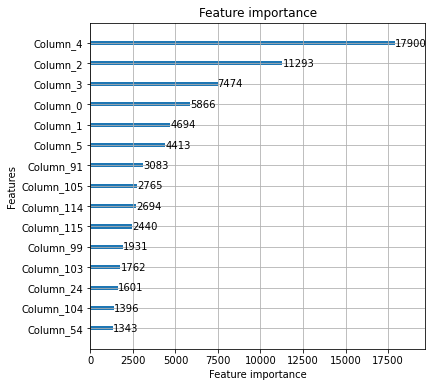

In [97]:
# Feature Importance
#column_4: Admission_deposit column_2: visitors with patients
from lightgbm import plot_importance
import matplotlib.pyplot as plt
%matplotlib inline

f, ax = plt.subplots(figsize=(6,6))
plot_importance(lgbm, max_num_features=15, ax=ax)